In [1]:
import torch
from torch import nn
#from d2l import torch as d2l
import pandas as pd
import numpy as np
from scipy import sparse

/home/artemy/bin/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
multi_atac_train_fn = "../data/competition_toy/atac_train.sparse.npz"
multi_atac_test_fn = "../data/competition_toy/atac_test.sparse.npz"
multi_gex_train_fn = "../data/competition_toy/gex_train.sparse.npz"
multi_gex_test_fn = "../data/competition_toy/gex_test.sparse.npz"

In [3]:
# https://d2l.ai/_modules/d2l/torch.html
import inspect


class HyperParameters:
    def save_hyperparameters(self, ignore=[]):
        """Defined in :numref:`sec_oo-design`"""
        raise NotImplemented

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes.
    
        Defined in :numref:`sec_utils`"""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

In [4]:
# https://www.kaggle.com/code/fabiencrom/msci-multiome-torch-quickstart-w-sparse-tensors

import collections


TorchCSR = collections.namedtuple("TrochCSR", "data indices indptr shape")

def load_csr_data_to_gpu(train_inputs):
    """Move a scipy csr sparse matrix to the gpu as a TorchCSR object
    This try to manage memory efficiently by creating the tensors and moving them to the gpu one by one
    """
    th_data = torch.from_numpy(train_inputs.data).to(device)
    th_indices = torch.from_numpy(train_inputs.indices).to(device)
    th_indptr = torch.from_numpy(train_inputs.indptr).to(device)
    th_shape = train_inputs.shape
    return TorchCSR(th_data, th_indices, th_indptr, th_shape)

def make_coo_batch(torch_csr, indx):
    """Make a coo torch tensor from a TorchCSR object by taking the rows indicated by the indx tensor
    """
    th_data, th_indices, th_indptr, th_shape = torch_csr
    start_pts = th_indptr[indx]
    end_pts = th_indptr[indx+1]
    coo_data = torch.cat([th_data[start_pts[i]: end_pts[i]] for i in range(len(start_pts))], dim=0)
    coo_col = torch.cat([th_indices[start_pts[i]: end_pts[i]] for i in range(len(start_pts))], dim=0)
    coo_row = torch.repeat_interleave(torch.arange(indx.shape[0], device=device), th_indptr[indx+1] - th_indptr[indx])
    coo_batch = torch.sparse_coo_tensor(torch.vstack([coo_row, coo_col]), coo_data, [indx.shape[0], th_shape[1]])
    return coo_batch


def make_coo_batch_slice(torch_csr, start, end):
    """Make a coo torch tensor from a TorchCSR object by taking the rows within the (start, end) slice
    """
    th_data, th_indices, th_indptr, th_shape = torch_csr
    start_pts = th_indptr[start]
    end_pts = th_indptr[end]
    coo_data = th_data[start_pts: end_pts]
    coo_col = th_indices[start_pts: end_pts]
    coo_row = torch.repeat_interleave(torch.arange(end-start, device=device), th_indptr[start+1:end+1] - th_indptr[start:end])
    coo_batch = torch.sparse_coo_tensor(torch.vstack([coo_row, coo_col]), coo_data, [end-start, th_shape[1]])
    return coo_batch



class DataLoaderCOO:
    """Torch compatible DataLoader. Works with in-device TorchCSR tensors.
    Args:
         - train_inputs, train_targets: TorchCSR tensors
         - train_idx: tensor containing the indices of the rows of train_inputs and train_targets that should be used
         - batch_size, shuffle, drop_last: as in torch.utils.data.DataLoader
    """
    def __init__(self, train_inputs, train_targets, train_idx=None, 
                 *,
                batch_size=512, shuffle=False, drop_last=False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        
        self.train_inputs = train_inputs
        self.train_targets = train_targets
        self.n_input_features = train_inputs.shape[1]
        self.n_target_features = train_targets.shape[1]
        
        self.train_idx = train_idx
        
        self.nb_examples = len(self.train_idx) if self.train_idx is not None else train_inputs.shape[0]
        
        self.nb_batches = self.nb_examples//batch_size
        if not drop_last and not self.nb_examples%batch_size==0:
            self.nb_batches +=1
        
    def __iter__(self):
        if self.shuffle:
            shuffled_idx = torch.randperm(self.nb_examples, device=device)
            if self.train_idx is not None:
                idx_array = self.train_idx[shuffled_idx]
            else:
                idx_array = shuffled_idx
        else:
            if self.train_idx is not None:
                idx_array = self.train_idx
            else:
                idx_array = None
            
        for i in range(self.nb_batches):
            slc = slice(i*self.batch_size, (i+1)*self.batch_size)
            if idx_array is None:
                inp_batch = make_coo_batch_slice(self.train_inputs, i*self.batch_size, (i+1)*self.batch_size)
                tgt_batch = make_coo_batch_slice(self.train_targets, i*self.batch_size, (i+1)*self.batch_size)
            else:
                idx_batch = idx_array[slc]
                inp_batch = make_coo_batch(self.train_inputs, idx_batch)
                tgt_batch = make_coo_batch(self.train_targets, idx_batch)
            yield inp_batch, tgt_batch
            
            
    def __len__(self):
        return self.nb_batches

In [5]:
# https://www.kaggle.com/code/fabiencrom/msci-multiome-torch-quickstart-w-sparse-tensors

def partial_correlation_score_torch_faster(y_true, y_pred):
    """Compute the correlation between each rows of the y_true and y_pred tensors.
    Compatible with backpropagation.
    """
    y_true = y_true.to_dense()
    y_pred = y_pred.to_dense()
    
    y_true_centered = y_true - torch.mean(y_true, dim=1)[:,None]
    y_pred_centered = y_pred - torch.mean(y_pred, dim=1)[:,None]
    cov_tp = torch.sum(y_true_centered*y_pred_centered, dim=1)/(y_true.shape[1]-1)
    var_t = torch.sum(y_true_centered**2, dim=1)/(y_true.shape[1]-1)
    var_p = torch.sum(y_pred_centered**2, dim=1)/(y_true.shape[1]-1)
    return cov_tp/torch.sqrt(var_t*var_p)

def correl_loss(pred, tgt):
    """Loss for directly optimizing the correlation.
    """
    return -torch.mean(partial_correlation_score_torch_faster(tgt, pred))

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


class Encoder(nn.Module, HyperParameters):
    def __init__(self,
                input_dim: int,
                n_layers: int = 2,
                out_dims: list = [30, 30]
    ):
        super().__init__()
        self.save_hyperparameters()
        
        modules = []
        for i in range(self.n_layers):
            input_dim = self.input_dim if i == 0 else self.out_dims[i-1]
            modules.append(nn.Linear(input_dim, self.out_dims[i]))
            modules.append(nn.BatchNorm1d(num_features=self.out_dims[i]))
            modules.append(nn.ReLU())
            
        self.Encoder = nn.Sequential(*modules) 
        self.Encoder.apply(init_weights)
    
    def forward(self, x):
        out = self.Encoder(x)
        return out
    
    
class Decoder(nn.Module, HyperParameters):
    def __init__(self,
                out_dim: int,
                input_dims: list = [30, 30],
                n_layers: int = 2
    ):
        super().__init__()
        self.save_hyperparameters()
        
        modules = []
        for i in range(self.n_layers):
            out_dim = self.out_dim if i == n_layers-1 else self.input_dims[i+1]
            modules.append(nn.Linear(self.input_dims[i], out_dim))
            modules.append(nn.BatchNorm1d(num_features=out_dim))
            modules.append(nn.ReLU())
            
        self.Decoder = nn.Sequential(*modules) 
        self.Decoder.apply(init_weights)
        
    def forward(self, x):
        out = self.Decoder(x)
        return out
    
    
class AE(nn.Module, HyperParameters):
    def __init__(self,
                n_atac_features: int,
                n_rna_features: int = None,
                atac_w: float = 0.5,
                lr: float = 3e-4):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(n_atac_features)
        self.decoder_atac = Decoder(n_atac_features)
        self.decoder_rna = Decoder(n_rna_features)
        
    def forward(self, x):
        out = self.encoder(x)
        atac_recon = self.decoder_atac(out)
        rna_recon = self.decoder_rna(out)
        return atac_recon, rna_recon
        
    #def loss(self, x_recon, x): # doesn't work with sparseCPU
    #    fn = nn.MSELoss()
    #    return fn(x_recon, x)
    
    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()
    
    def training_step(self, inputs, targets):
        atac_recon, rna_recon = self.forward(inputs)
        loss_atac = self.loss(atac_recon, inputs)
        loss_rna = self.loss(rna_recon, targets)
        cor = correl_loss(rna_recon, targets)
        return loss_atac, loss_rna, cor
    
    def validation_step(self, inputs, targets):
        atac_recon, rna_recon = self.forward(inputs)
        loss_atac = self.loss(atac_recon, inputs)
        loss_rna = self.loss(rna_recon, targets)
        cor = correl_loss(rna_recon, targets)
        return loss_atac, loss_rna, cor
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), self.lr)
    
class Trainer(HyperParameters):
    def __init__(self,
                 atac_w: float = 0.5,
                 lr: float = 3e-4,
                 max_epochs = 100):
        self.save_hyperparameters()
        
    def prepare_model(self, model):
        model = model(self.train_loader.n_input_features,
              self.train_loader.n_target_features,
              self.atac_w,
              self.lr
              )
        model.to(device)
        return model

    def fit(self, model):
        self.train_loader, self.val_loader = self.load_data('train')
        self.model = self.prepare_model(model)
        self.optim = self.model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        self.train_progress = [[], []]
        self.val_progress = [[], []]
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
            
    def fit_epoch(self):
        self.model.train()
        loss_atac_sum = torch.tensor(0., device=device)
        loss_rna_sum = torch.tensor(0., device=device)
        cor_sum = torch.tensor(0., device=device)
        for batch_inputs, batch_targets in self.train_loader:
            loss_atac, loss_rna, cor = self.model.training_step(batch_inputs, batch_targets)
            loss_atac_sum += loss_atac
            loss_rna_sum += loss_rna
            cor_sum += cor
            loss = self.atac_w * loss_atac + (1-self.atac_w) * loss_rna 
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            self.train_batch_idx += 1
        mean_atac_loss = float(loss_atac_sum)/ self.train_batch_idx
        mean_rna_loss= float(loss_rna_sum)/ self.train_batch_idx
        mean_cor = float(cor_sum)/ self.train_batch_idx
        self.train_progress[0].append(mean_atac_loss)
        self.train_progress[1].append(mean_rna_loss)
        print(f'EPOCH {self.epoch}')
        print('Train ATAC loss:', mean_atac_loss)
        print('Train RNA loss:', mean_rna_loss)
        print('Train RNA cor:', mean_cor)
        
        self.model.eval()
        loss_atac_sum = torch.tensor(0., device=device)
        loss_rna_sum = torch.tensor(0., device=device)
        cor_sum = torch.tensor(0., device=device)
        for batch_inputs, batch_targets in self.val_loader:
            loss_atac, loss_rna, cor = self.model.validation_step(batch_inputs, batch_targets)
            loss_atac_sum += loss_atac
            loss_rna_sum += loss_rna
            cor_sum += cor
            self.val_batch_idx += 1
        mean_atac_loss = float(loss_atac_sum)/ self.val_batch_idx
        mean_rna_loss= float(loss_rna_sum)/ self.val_batch_idx
        mean_cor = float(cor_sum)/ self.val_batch_idx
        self.val_progress[0].append(mean_atac_loss)
        self.val_progress[1].append(mean_rna_loss)
        print('Validation ATAC loss:', mean_atac_loss)
        print('Validation RNA loss:', mean_rna_loss)
        print('Validation RNA cor:', mean_cor)
        print('\n')
        
    def test_model(self):
        self.test_loader = self.load_data('test')
        self.test_batch_idx = 0
        
        self.model.eval()
        loss_atac_sum = torch.tensor(0., device=device)
        loss_rna_sum = torch.tensor(0., device=device)
        cor_sum = torch.tensor(0., device=device)
        for batch_inputs, batch_targets in self.test_loader:
            loss_atac, loss_rna, cor = self.model.validation_step(batch_inputs, batch_targets)
            loss_atac_sum += loss_atac
            loss_rna_sum += loss_rna
            cor_sum += cor
            self.test_batch_idx += 1
        print('Test ATAC loss:', float(loss_atac_sum) / self.test_batch_idx)
        print('Test RNA loss:', float(loss_rna_sum) / self.test_batch_idx)
        print('Test RNA cor:', float(cor_sum) / self.test_batch_idx)
        print('\n')
            

    def load_data(self,
                  dset: str = 'train',
                  cv_split: bool = True,
                  batch_size: int = 512
                  ):
        if dset == 'train':
            inputs_fn = multi_atac_train_fn
            targets_fn = multi_gex_train_fn
        elif dset == 'test':
            inputs_fn = multi_atac_test_fn
            targets_fn = multi_gex_test_fn
        inputs = sparse.load_npz(inputs_fn)
        targets = sparse.load_npz(targets_fn)
        
        inputs = load_csr_data_to_gpu(inputs)
        targets = load_csr_data_to_gpu(targets)

        if cv_split and dset == 'train':
            idx = np.arange(targets.shape[0])
            val_idx = np.random.choice(idx, 512*8, replace=False)
            train_idx = idx[~np.isin(idx, val_idx)]
            train_loader = DataLoaderCOO(inputs, targets, 
                                         train_idx=train_idx,
                                         batch_size=batch_size,
                                         drop_last=True)
            val_loader = DataLoaderCOO(inputs, targets,
                                       train_idx=val_idx,
                                       batch_size=batch_size,
                                       drop_last=True)
            return train_loader, val_loader
        else:
            loader = DataLoaderCOO(inputs, targets, 
                                         batch_size=batch_size,
                                         drop_last=True)
            return loader


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
else:
    device = torch.device("cpu")

Using GPU


In [8]:
if 'trainer' in globals():
    del trainer.model
torch.cuda.empty_cache()


trainer = Trainer()
trainer.fit(AE)

EPOCH 0
Train ATAC loss: 0.1582219704337742
Train RNA loss: 2.006539717964504
Train RNA cor: -0.019717860481013424
Validation ATAC loss: 0.07537905871868134
Validation RNA loss: 2.041757345199585
Validation RNA cor: -0.11096850037574768


EPOCH 1
Train ATAC loss: 0.04759575491366179
Train RNA loss: 0.9617405767026155
Train RNA cor: -0.06160332327303679
Validation ATAC loss: 0.044927068054676056
Validation RNA loss: 0.953879177570343
Validation RNA cor: -0.07936263084411621


EPOCH 2
Train ATAC loss: 0.02794928827147553
Train RNA loss: 0.6277115863302479
Train RNA cor: -0.06947849798893584
Validation ATAC loss: 0.02741828312476476
Validation RNA loss: 0.6339050134023031
Validation RNA cor: -0.06584403415520985


EPOCH 3
Train ATAC loss: 0.019628527371779732
Train RNA loss: 0.4646603957466457
Train RNA cor: -0.06340260609336522
Validation ATAC loss: 0.019289134070277214
Validation RNA loss: 0.47505810856819153
Validation RNA cor: -0.0544973760843277


EPOCH 4
Train ATAC loss: 0.015171864

Validation ATAC loss: 0.002117613220916075
Validation RNA loss: 0.05236175831626443
Validation RNA cor: -0.011187365826438455


EPOCH 34
Train ATAC loss: 0.0020551407559317833
Train RNA loss: 0.047364082099488065
Train RNA cor: -0.011151061443068227
Validation ATAC loss: 0.0020578612174306597
Validation RNA loss: 0.050419643947056364
Validation RNA cor: -0.010678795405796596


EPOCH 35
Train ATAC loss: 0.001997965545470012
Train RNA loss: 0.04593910917567746
Train RNA cor: -0.01087659107890106
Validation ATAC loss: 0.0019998858786291545
Validation RNA loss: 0.049047632349861994
Validation RNA cor: -0.01049357404311498


EPOCH 36
Train ATAC loss: 0.0019438842488792051
Train RNA loss: 0.0445926186620979
Train RNA cor: -0.010620985692312238
Validation ATAC loss: 0.0019493991056004085
Validation RNA loss: 0.047722394401962694
Validation RNA cor: -0.010372614538347398


EPOCH 37
Train ATAC loss: 0.001892658747579195
Train RNA loss: 0.04332040049118636
Train RNA cor: -0.010378002847632227
Va

Validation ATAC loss: 0.0010752377670202682
Validation RNA loss: 0.024778766418570904
Validation RNA cor: -0.006411267750298799


EPOCH 67
Train ATAC loss: 0.001057094396532649
Train RNA loss: 0.022767849895350464
Train RNA cor: -0.00634466900545008
Validation ATAC loss: 0.0010594862568027834
Validation RNA loss: 0.024431840461843154
Validation RNA cor: -0.006369594265432919


EPOCH 68
Train ATAC loss: 0.0010417605167525928
Train RNA loss: 0.022387511187855674
Train RNA cor: -0.006274685442034524
Validation ATAC loss: 0.0010428751508394878
Validation RNA loss: 0.02415850369826607
Validation RNA cor: -0.006233432586642279


EPOCH 69
Train ATAC loss: 0.001026873188729612
Train RNA loss: 0.02201823122012689
Train RNA cor: -0.006203923314254477
Validation ATAC loss: 0.0010273048920290812
Validation RNA loss: 0.023590903622763497
Validation RNA cor: -0.006172404970441546


EPOCH 70
Train ATAC loss: 0.001012436028134217
Train RNA loss: 0.02166037901150107
Train RNA cor: -0.006133953778932085

Validation ATAC loss: 0.0007194048166275025
Validation RNA loss: 0.015879064798355103
Validation RNA cor: -0.004580117166042328




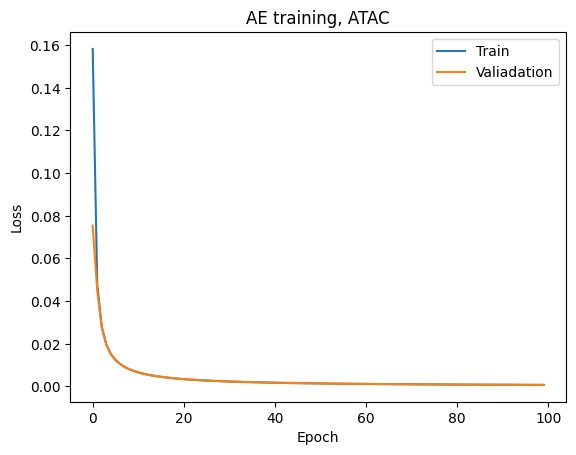

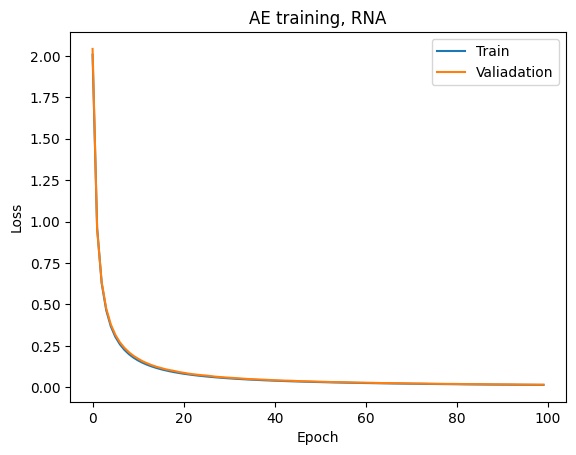

In [11]:
import matplotlib.pyplot as plt


plt.plot(np.arange(len(trainer.train_progress[0])), (trainer.train_progress[0]), label='Train')
plt.plot(np.arange(len(trainer.val_progress[0])), (trainer.val_progress[0]), label='Valiadation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('AE training, ATAC')
plt.legend()
plt.show()

plt.plot(np.arange(len(trainer.train_progress[1])), (trainer.train_progress[1]), label='Train')
plt.plot(np.arange(len(trainer.val_progress[1])), (trainer.val_progress[1]), label='Valiadation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('AE training, RNA')
plt.legend()
plt.show()

In [12]:
trainer.test_model() # don't know how to fix this memory problem

RuntimeError: CUDA out of memory. Tried to allocate 448.00 MiB (GPU 0; 23.69 GiB total capacity; 21.42 GiB already allocated; 419.69 MiB free; 22.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF